In [1]:
# Import necessary libraries
import os
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

class FraudDetectionProject:
    def __init__(self, config):
        """
        Initialize the project with a configuration dictionary.
        """
        self.dataset_url = config['dataset_url']
        self.dataset_path = config['dataset_path']
        self.model_path = config['model_path']
        self.model_type = config['model_type']
        self.df = None
        self.model = None
    
    def download_data(self):
        """
        Download the dataset if it does not exist locally.
        """
        if not os.path.exists(self.dataset_path):
            print("Downloading dataset...")
            response = requests.get(self.dataset_url)
            with open(self.dataset_path, 'wb') as f:
                f.write(response.content)
            print(f"Dataset downloaded at {self.dataset_path}")
        else:
            print("Dataset already exists.")
    
    def load_data(self):
        """
        Load the dataset into a Pandas DataFrame.
        """
        print("Loading dataset...")
        self.df = pd.read_csv(self.dataset_path)
        print(f"Dataset loaded with {self.df.shape[0]} rows and {self.df.shape[1]} columns.")
    
    def preprocess_data(self):
        """
        Preprocess the data: split into features and labels, then into training and test sets.
        """
        print("Preprocessing dataset...")
        X = self.df.drop(columns=['Class'])  # Features
        y = self.df['Class']  # Target (fraud label)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        print("Data preprocessing completed.")
        return X_train, X_test, y_train, y_test
    
    def train_model(self, X_train, y_train):
        """
        Train a RandomForest model (or another model type specified).
        """
        print(f"Training {self.model_type} model...")
        
        if self.model_type == 'RandomForest':
            self.model = RandomForestClassifier(n_estimators = 100, random_state = 0)
        else:
            raise NotImplementedError(f"Model {self.model_type} is not implemented.")
        
        self.model.fit(X_train, y_train)
        joblib.dump(self.model, self.model_path)
        print(f"Model saved at {self.model_path}")
    
    def load_model(self):
        """
        Load the trained model from file.
        """
        if os.path.exists(self.model_path):
            self.model = joblib.load(self.model_path)
            print(f"Model loaded from {self.model_path}")
        else:
            print("Model not found. Please train the model first.")
    
    def evaluate_model(self, X_test, y_test):
        """
        Evaluate the model on the test data and print out classification report and confusion matrix.
        """
        if self.model is None:
            print("Model is not loaded. Please load or train the model first.")
            return
        
        print("Making predictions and evaluating the model...")
        y_pred = self.model.predict(X_test)
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

In [2]:
config = {
    'dataset_url': 'https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/download?resource=download',
    'dataset_path': 'data/creditcard.csv',
    'model_path': 'models/fraud_detection_model.pkl',
    'model_type': 'RandomForest'
}

Loading dataset...
Dataset loaded with 284807 rows and 31 columns.
Preprocessing dataset...
Data preprocessing completed.
Training RandomForest model...
Model saved at models/fraud_detection_model.pkl
Making predictions and evaluating the model...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.94      0.76      0.84       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



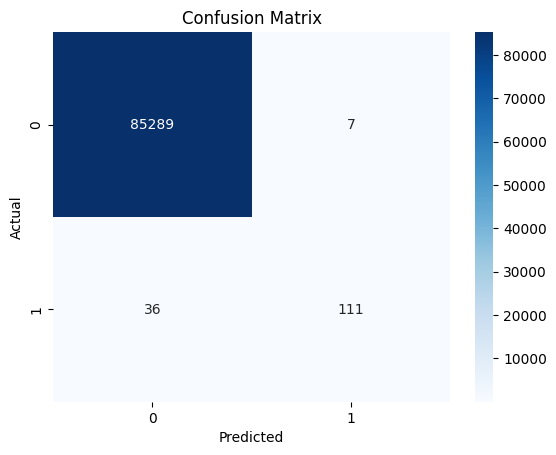

In [3]:
# Initialize the FraudDetectionProject class with the config
fraud_project = FraudDetectionProject(config)

# Download the dataset
# fraud_project.download_data()

# Load the dataset
fraud_project.load_data()

# Preprocess the data
X_train, X_test, y_train, y_test = fraud_project.preprocess_data()

# Train the model
fraud_project.train_model(X_train, y_train)

# Evaluate the model
fraud_project.evaluate_model(X_test, y_test)